In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
# calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
#                 21102, 22277, 26761, 28378, 29128, 38148, 41020, 
#                 41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]
# I_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588,
#             40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814]


########### Updated list using the color-LogWimx correaltion
calib_maglim = [3974, 6699, 19871, 22277, 28378, 38148, 41020, 41093, 46127, 49448, 53641]
calib_maglim += [6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 44982, 45084, 46127, 67908, 72228]

I_maglim = [38803,   39181,   39431,   39619,   40005,   40107,   40588,   40604,
   41567,   41829,   42768, 5807403, 5057729,   37814]
I_maglim += [38803, 39181, 39431, 40005, 40107, 40147, 41567, 42768]

In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

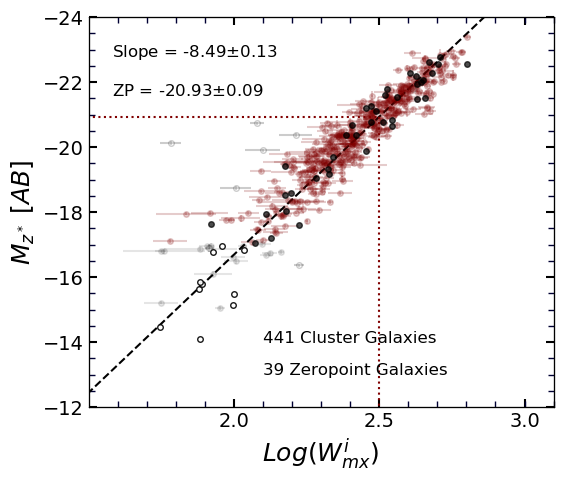

In [4]:
band = 'z'

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True)

In [5]:
slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

print S_ZP

Clusters_orig = allCluster(table, band=band, pgcFaint=I_maglim)

[ -8.48793164   0.13191456 -20.93392844   0.08987883]


In [6]:
d_lst = []
keys = []
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        print key, myCluster['slope'], myCluster['zp'], Clusters_orig[key]['zp']-zp, Clusters_orig[key]['name']
        
        d_modulus = Clusters_orig[key]['zp']-zp
        d_lst.append(d_modulus)
        keys.append(key)

print 

indx  = np.argsort(d_lst)

for i in indx:
    key = keys[i]
    print key, '%.1f'%d_lst[i], Clusters_orig[key]['name']

NEST_200092 -8.487931642146052 12.343012593023648 33.07877991045525 Pegasus
NEST_200037 -8.487931642146052 13.599008507359162 34.5911910473876 NGC70
NEST_200005 -8.487931642146052 13.027914109348423 33.96739767551865 NGC410
NEST_200006 -8.487931642146052 12.960829886937614 33.89018009977891 NGC507
NEST_200012 -8.487931642146052 13.886286173319345 34.811182445290946 Abell 400
NEST_200003 -8.487931642146052 12.467145313684703 33.63482646664614 Abell 262
NEST_100001 -8.487931642146052 13.856919052893613 34.78522519982508 Coma
NEST_100002 -8.487931642146052 9.935088670281136 31.01684332908078 Virgo
NEST_100005 -8.487931642146052 13.834602839182955 34.76193875046576 Abell 1367
NEST_200045 -8.487931642146052 13.557120739301194 34.51114247084787 NGC80
NEST_100007 -8.487931642146052 14.985996705889777 35.89185136004018 Abell 2151 (Hercules)
NEST_200016 -8.487931642146052 14.276785933197937 35.214935002084765 Abell 2634/66
NEST_100008 -8.487931642146052 10.346144656252712 31.275996187420283 Urs

In [7]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    rms = np.sqrt(np.mean((mag-mag_fit)**2))
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS
    

Virgo (24) -7.24 0.42 10.08 0.09 9.94 0.09 0.84


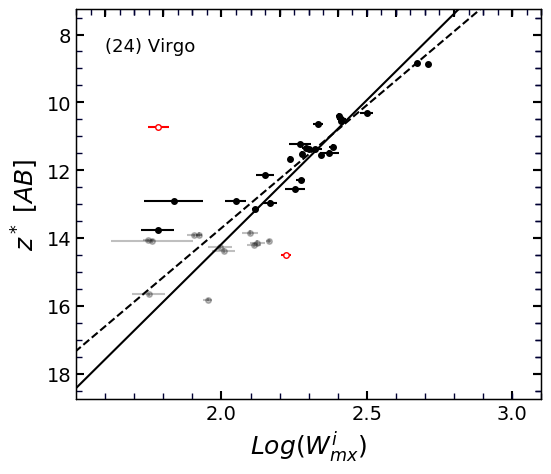

In [8]:
##########################################
def plotSingleCluster(key, xLim = (1.5,3.1), yLim = (18.75,7.25)):
#         key = 'NEST_100002'
    logWimx_, mag_, logWimx_e_, mag_e_ = plotCluster(ax, Clusters, nest=key, plotErrors=True, alpha=1., 
                        markersize=0, pgcFaint=I_maglim, plotWeird=True, color='k', 
                        alphaFaint=0.25, weirdColor='r', alphaWeird=1.)
    
    ## solid line, universal fit
    x = np.linspace(-5,5,50)
    y = slope*(x-2.5)+Clusters[key]['zp']
    ax.plot(x,y, 'k-')  
    
    
    ## dashed line, original fit
    y = Clusters_orig[key]['slope']*(x-2.5)+Clusters_orig[key]['zp']
    ax.plot(x,y, 'k--')  
    
    
    Sorig = Clusters_orig[key]['slope']
    Sorig_e = Clusters_orig[key]['slope_e']
    ZPorig = Clusters_orig[key]['zp']
    ZPorig_e = Clusters_orig[key]['zp_e']
    Zp_univ = Clusters[key]['zp']
    Zp_univ_e = Clusters[key]['zp_e']
    rms, RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, Zp_univ)
    print Clusters_orig[key]['name'], '(%d)'%len(logWimx_), '%.2f'%Sorig, '%.2f'%Sorig_e, '%.2f'%ZPorig, '%.2f'%ZPorig_e, '%.2f'%Zp_univ, '%.2f'%Zp_univ_e, '%.2f'%rms
    
    
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
            
    ax.text(1.6,8.5, r''+"(%d)" % len(logWimx_)+' '+Clusters[key]['name'], fontsize=13)
    
##########################################    
    
    

fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (18.75,7.25))
plotSingleCluster('NEST_100002')

Virgo (24) -7.24 0.42 10.08 0.09 9.94 0.09 0.84
Ursa Major (37) -8.55 0.44 10.34 0.08 10.35 0.07 0.53
Pegasus (26) -9.64 1.08 12.14 0.22 12.34 0.11 0.58
Abell 262 (7) -7.16 1.26 12.70 0.28 12.47 0.21 0.72
NGC507 (20) -7.49 0.49 12.96 0.09 12.96 0.10 0.45
NGC410 (34) -8.28 0.54 13.03 0.08 13.03 0.08 0.53
Cancer (18) -8.37 0.87 13.23 0.12 13.23 0.11 0.49
NGC80 (14) -7.53 0.56 13.58 0.06 13.56 0.07 0.41
NGC70 (11) -9.33 1.25 13.66 0.15 13.60 0.10 0.36
Abell 1367 (68) -8.72 0.44 13.83 0.06 13.83 0.06 0.55
Coma (79) -8.87 0.40 13.85 0.06 13.86 0.06 0.56
Abell 400 (21) -7.77 0.45 13.88 0.06 13.89 0.06 0.57
NGC4065 (14) -8.85 0.53 14.15 0.09 14.16 0.08 0.37
Abell 2634/66 (29) -8.54 0.63 14.28 0.09 14.28 0.06 0.49
Abell 2151 (Hercules) (39) -8.12 0.50 14.96 0.07 14.99 0.06 0.43


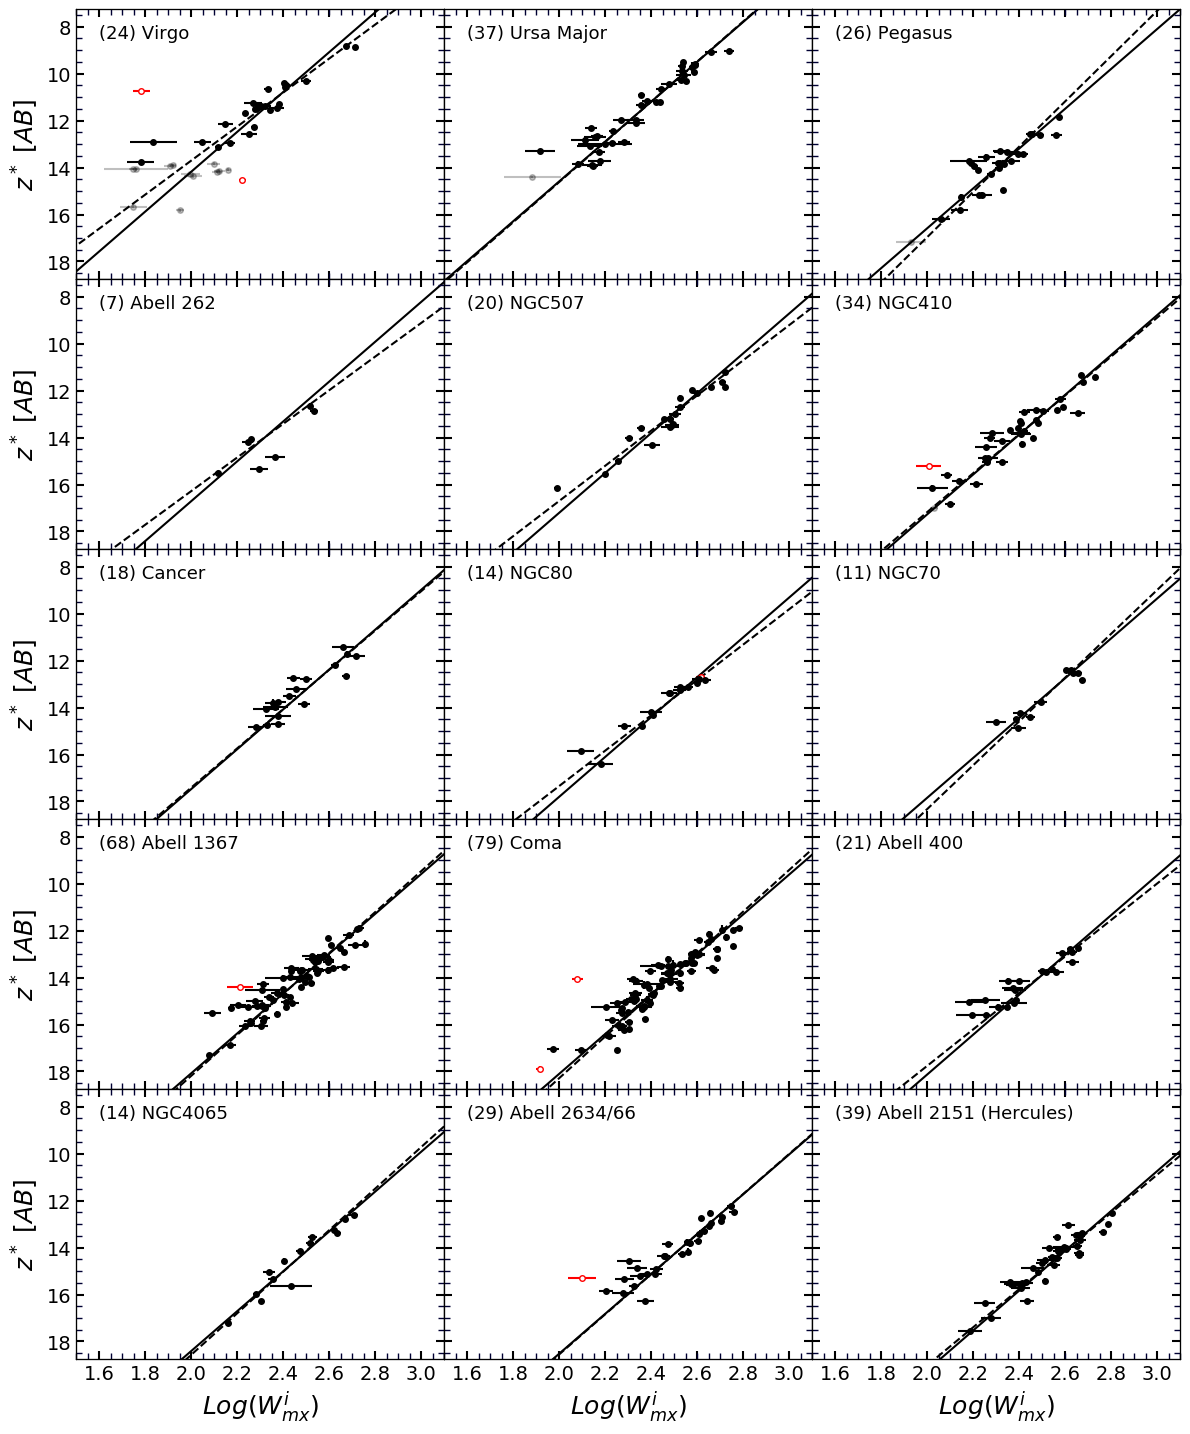

In [9]:
fig = py.figure(figsize=(12, 15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(5, 3); p=0


for i in indx:
    key = keys[i]
    ax = plt.subplot(gs[p])
    plotSingleCluster(key)
    
    if p%3==0: 
        ax.set_ylabel(r'$'+band+'^* \/\/ [AB]$', fontsize=18)
    else:
        plt.setp(ax.get_yticklabels(), visible=False) 
        
    if p>11: ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
    p+=1

plt.subplots_adjust(hspace=.0, wspace=0)

In [10]:
myKeys = ['NEST_100002', 'NEST_100008', 'NEST_200092',  'NEST_200003', 'NEST_200005', 'NEST_200006', 'NEST_100030', 'NEST_200045', 'NEST_200037', 'NEST_100005', 'NEST_100001', 'NEST_200012', 'NEST_100018', 'NEST_200016', 'NEST_100007']

for key in myKeys:
    myCluster = Clusters[key]
    
    mag = myCluster['mag']
    pgc = myCluster['pgc']
    ix = []
    for i, id in enumerate(pgc):
        if not id in I_maglim:
            ix.append(i)  
    
    mags = mag[ix]
    jj = np.argsort(mags)
    
    print mags[jj][::-1][1]
    

    

13.14
13.89
15.8
15.33
16.15
15.55
14.76
15.85
14.61
16.89
17.08
15.59
16.28
15.95
17.01
